In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()  # Tải file kaggle.json lên ColabX

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d vencerlanz09/sea-animals-image-dataste
!unzip sea-animals-image-dataste.zip -d sea_animals_dataset

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: sea_animals_dataset/Seahorse/9891995103_849905035f_o.jpg  
  inflating: sea_animals_dataset/Seahorse/9984393_fb8ac77d6a_o.jpg  
  inflating: sea_animals_dataset/Seahorse/Sea Horse (1).jpg  
  inflating: sea_animals_dataset/Seahorse/Sea Horse (10).jpg  
  inflating: sea_animals_dataset/Seahorse/Sea Horse (11).jpg  
  inflating: sea_animals_dataset/Seahorse/Sea Horse (12).jpg  
  inflating: sea_animals_dataset/Seahorse/Sea Horse (13).jpg  
  inflating: sea_animals_dataset/Seahorse/Sea Horse (14).jpg  
  inflating: sea_animals_dataset/Seahorse/Sea Horse (15).jpg  
  inflating: sea_animals_dataset/Seahorse/Sea Horse (16).jpg  
  inflating: sea_animals_dataset/Seahorse/Sea Horse (17).jpg  
  inflating: sea_animals_dataset/Seahorse/Sea Horse (18).jpg  
  inflating: sea_animals_dataset/Seahorse/Sea Horse (19).jpg  
  inflating: sea_animals_dataset/Seahorse/Sea Horse (2).jpg  
  inflating: sea_animals_dataset/Seahorse/Sea Ho

In [ ]:
import os
import shutil
from google.colab import drive

# Định nghĩa danh sách 9 lớp cần giữ
desired_classes = ['Sea Urchins', 'Puffers', 'Seahorse', 'Lobster', 'Otter', 'Crabs', 'Starfish', 'Squid', 'Octopus']

# Đường dẫn đến thư mục chứa dữ liệu đã giải nén
dataset_dir = '/content/sea_animals_dataset'

# Lấy danh sách tất cả các thư mục (lớp)
all_classes = os.listdir(dataset_dir)

# Xóa các thư mục không thuộc danh sách desired_classes
for class_name in all_classes:
    class_path = os.path.join(dataset_dir, class_name)
    if class_name not in desired_classes and os.path.isdir(class_path):
        shutil.rmtree(class_path)
        print(f"Đã xóa thư mục: {class_name}")

# Kiểm tra các lớp còn lại
remaining_classes = os.listdir(dataset_dir)
print("Các lớp còn lại sau khi lọc:", remaining_classes)

# Kết nối Google Drive
drive.mount('/content/drive')

# Đường dẫn đích trên Google Drive
destination_dir = '/content/drive/My Drive/sea_animals_dataset_filtered'

# Sao chép thư mục đã lọc
shutil.copytree(dataset_dir, destination_dir, dirs_exist_ok=True)
print(f"Đã sao chép dữ liệu đã lọc vào: {destination_dir}")

# Nén thành file zip (tùy chọn)
zip_path = '/content/drive/My Drive/sea_animals_dataset_filtered.zip'
shutil.make_archive('/content/drive/My Drive/sea_animals_dataset_filtered', 'zip', dataset_dir)
print(f"Đã nén và lưu file zip vào: {zip_path}")

Đã xóa thư mục: Turtle_Tortoise
Đã xóa thư mục: Shrimp
Đã xóa thư mục: Dolphin
Đã xóa thư mục: Clams
Đã xóa thư mục: Corals
Đã xóa thư mục: Jelly Fish
Đã xóa thư mục: Sharks
Đã xóa thư mục: Penguin
Đã xóa thư mục: Whale
Đã xóa thư mục: Fish
Đã xóa thư mục: Nudibranchs
Đã xóa thư mục: Sea Rays
Đã xóa thư mục: Seal
Đã xóa thư mục: Eel
Các lớp còn lại sau khi lọc: ['Lobster', 'Puffers', 'Starfish', 'Crabs', 'Seahorse', 'Octopus', 'Otter', 'Sea Urchins', 'Squid']
Mounted at /content/drive
Đã sao chép dữ liệu đã lọc vào: /content/drive/My Drive/sea_animals_dataset_filtered
Đã nén và lưu file zip vào: /content/drive/My Drive/sea_animals_dataset_filtered.zip


In [ ]:
import os
import cv2
import hashlib
from PIL import Image
import numpy as np
from pathlib import Path

# Đường dẫn đến thư mục dataset đã lọc từ cell trước
dataset_dir = '/content/sea_animals_dataset'

# Danh sách định dạng ảnh hợp lệ
valid_formats = {'.jpg', '.jpeg', '.png'}

def is_valid_image(file_path):
    """Kiểm tra xem file có phải là ảnh hợp lệ không"""
    try:
        # Thử mở ảnh bằng PIL để kiểm tra tính toàn vẹn
        img = Image.open(file_path)
        img.verify()  # Xác minh ảnh
        img.close()

        # Thử đọc ảnh bằng OpenCV
        img_cv = cv2.imread(file_path)
        if img_cv is None:
            return False

        return True
    except Exception as e:
        print(f"Lỗi khi kiểm tra ảnh {file_path}: {str(e)}")
        return False

def get_image_hash(file_path):
    """Tính hash của ảnh để phát hiện trùng lặp"""
    try:
        with open(file_path, 'rb') as f:
            img_data = f.read()
            return hashlib.md5(img_data).hexdigest()
    except Exception as e:
        print(f"Lỗi khi tính hash cho {file_path}: {str(e)}")
        return None

def clean_dataset(dataset_dir):
    """Làm sạch dataset: xóa ảnh lỗi, ảnh trùng lặp và kiểm tra định dạng"""
    image_hashes = {}  # Lưu hash để kiểm tra trùng lặp
    removed_count = 0
    total_count = 0

    # Duyệt qua tất cả các thư mục lớp
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        print(f"Đang xử lý lớp: {class_name}")

        # Duyệt qua tất cả các file trong thư mục lớp
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            total_count += 1

            # Kiểm tra định dạng file
            file_ext = os.path.splitext(file_name)[1].lower()
            if file_ext not in valid_formats:
                print(f"Xóa file không đúng định dạng: {file_path}")
                os.remove(file_path)
                removed_count += 1
                continue

            # Kiểm tra ảnh lỗi
            if not is_valid_image(file_path):
                print(f"Xóa ảnh lỗi: {file_path}")
                os.remove(file_path)
                removed_count += 1
                continue

            # Kiểm tra ảnh trùng lặp
            img_hash = get_image_hash(file_path)
            if img_hash is None:
                print(f"Xóa ảnh không thể hash: {file_path}")
                os.remove(file_path)
                removed_count += 1
                continue

            if img_hash in image_hashes:
                print(f"Xóa ảnh trùng lặp: {file_path} (giống với {image_hashes[img_hash]})")
                os.remove(file_path)
                removed_count += 1
                continue

            image_hashes[img_hash] = file_path

    print(f"\nKết quả làm sạch:")
    print(f"Tổng số file đã kiểm tra: {total_count}")
    print(f"Số file đã xóa: {removed_count}")
    print(f"Số file còn lại: {total_count - removed_count}")

    # Kiểm tra số lượng ảnh trong mỗi lớp
    print("\nSố lượng ảnh trong mỗi lớp sau khi làm sạch:")
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            print(f"Lớp {class_name}: {num_images} ảnh")

# Thực thi quá trình làm sạch
clean_dataset(dataset_dir)

# Cập nhật Google Drive với dataset đã làm sạch
import shutil
destination_dir = '/content/drive/My Drive/sea_animals_dataset_filtered'
shutil.copytree(dataset_dir, destination_dir, dirs_exist_ok=True)
print(f"Đã cập nhật dataset đã làm sạch vào: {destination_dir}")

# Nén lại dataset đã làm sạch
zip_path = '/content/drive/My Drive/sea_animals_dataset_filtered_cleaned.zip'
shutil.make_archive('/content/drive/My Drive/sea_animals_dataset_filtered_cleaned', 'zip', dataset_dir)
print(f"Đã nén và lưu file zip đã làm sạch vào: {zip_path}")

Đang xử lý lớp: Lobster
Đang xử lý lớp: Puffers
Đang xử lý lớp: Starfish
Xóa ảnh trùng lặp: /content/sea_animals_dataset/Starfish/26023545144_7e173d3dde_o.jpg (giống với /content/sea_animals_dataset/Puffers/26023545144_7e173d3dde_o.jpg)
Đang xử lý lớp: Crabs
Đang xử lý lớp: Seahorse
Xóa ảnh trùng lặp: /content/sea_animals_dataset/Seahorse/5120704764_1039a3dab2_o.jpg (giống với /content/sea_animals_dataset/Seahorse/5120625360_5a41f45599_o.jpg)
Đang xử lý lớp: Octopus
Xóa ảnh trùng lặp: /content/sea_animals_dataset/Octopus/23683207094_f22da34528_b.jpg (giống với /content/sea_animals_dataset/Puffers/23683207094_f22da34528_b.jpg)
Xóa ảnh trùng lặp: /content/sea_animals_dataset/Octopus/21387927708_07841db656_o.jpg (giống với /content/sea_animals_dataset/Octopus/26178694450_ca915b6215_o.jpg)
Đang xử lý lớp: Otter
Xóa ảnh trùng lặp: /content/sea_animals_dataset/Otter/3648067832_75017b4c35_o.jpg (giống với /content/sea_animals_dataset/Otter/4772002061_f9427f5bfb_o.jpg)
Xóa ảnh trùng lặp: /cont

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Giải nén file /content/drive/My Drive/sea_animals_dataset_filtered_cleaned.zip...
Đã giải nén dữ liệu vào: /content/sea_animals_dataset_cleaned
Các lớp trong dataset: ['Lobster', 'Puffers', 'Starfish', 'Crabs', 'Seahorse', 'Octopus', 'Otter', 'Sea Urchins', 'Squid']


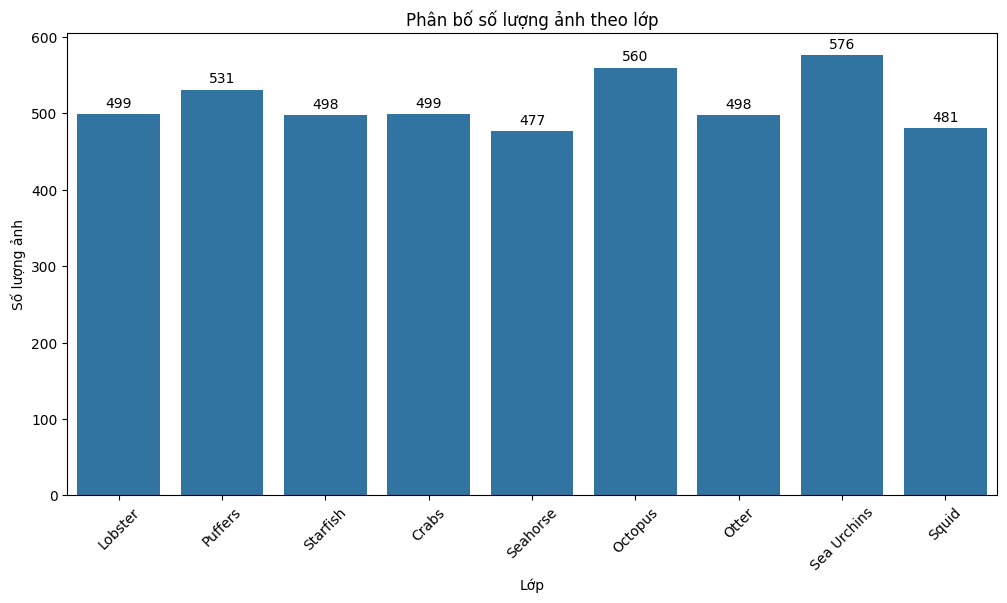

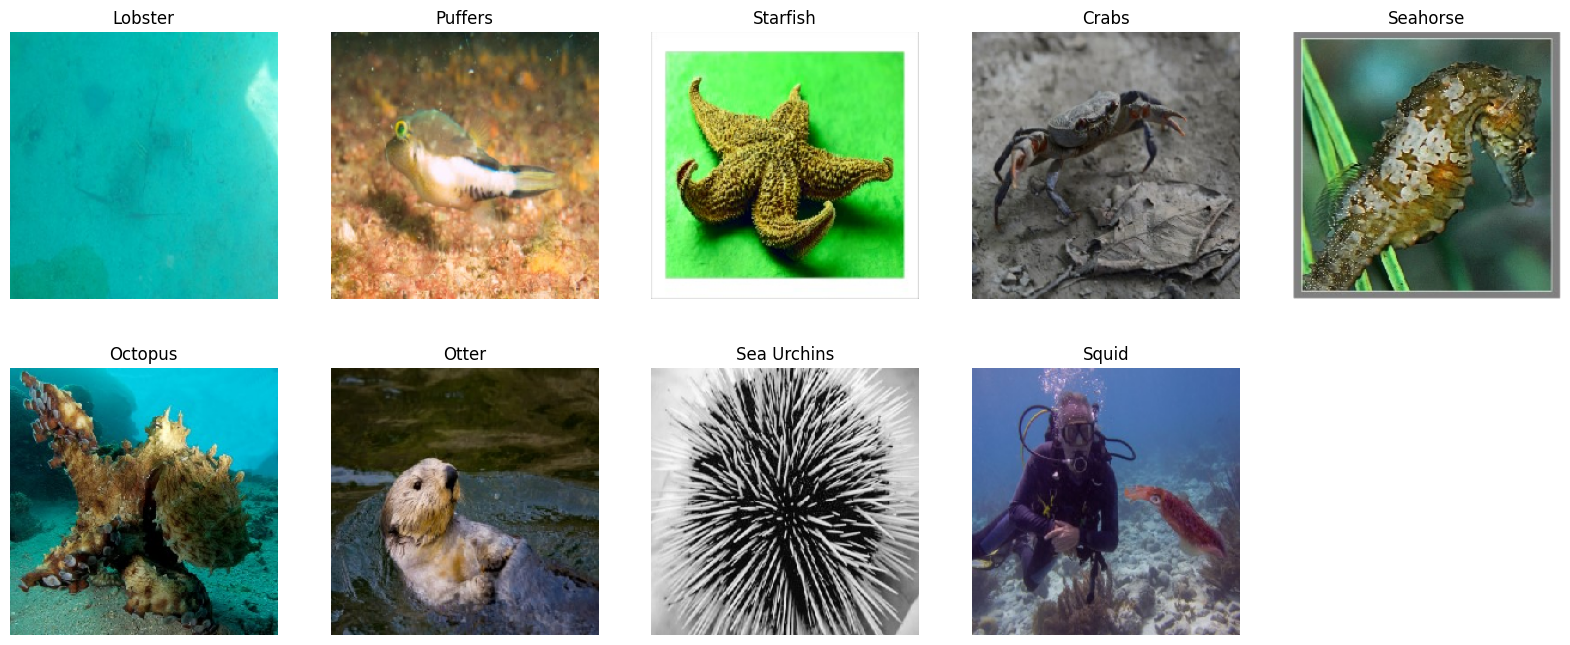

Thư mục split_dataset không tồn tại, cần chia dữ liệu lại


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from google.colab import drive
import random
import shutil
import zipfile

# Kết nối Google Drive
drive.mount('/content/drive')

# Đường dẫn tới file zip đã làm sạch
zip_path = '/content/drive/My Drive/sea_animals_dataset_filtered_cleaned.zip'
cleaned_dataset_dir = '/content/sea_animals_dataset_cleaned'

# Kiểm tra xem file zip đã làm sạch có tồn tại không
if not os.path.exists(zip_path):
    print(f"File {zip_path} không tồn tại trong Google Drive. Kiểm tra lại!")
    # (Tùy chọn) Có thể thêm mã tải lại dataset nếu cần
else:
    # Giải nén file zip
    print(f"Giải nén file {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(cleaned_dataset_dir)
    print(f"Đã giải nén dữ liệu vào: {cleaned_dataset_dir}")

# Sử dụng thư mục đã giải nén làm dataset_dir
dataset_dir = cleaned_dataset_dir

# Kiểm tra các lớp hiện có
desired_classes = ['Sea Urchins', 'Puffers', 'Seahorse', 'Lobster', 'Otter', 'Crabs', 'Starfish', 'Squid', 'Octopus']
remaining_classes = os.listdir(dataset_dir)
print("Các lớp trong dataset:", remaining_classes)
if set(remaining_classes) != set(desired_classes):
    print("Cảnh báo: Dataset không chứa đúng 9 lớp mong muốn!")

# Đếm số lượng ảnh trong mỗi lớp
class_counts = {}
for class_name in remaining_classes:
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Trực quan hóa phân bố số lượng ảnh
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Phân bố số lượng ảnh theo lớp')
plt.xticks(rotation=45)
plt.ylabel('Số lượng ảnh')
plt.xlabel('Lớp')
for i, v in enumerate(class_counts.values()):
    ax.text(i, v + 5, str(v), ha='center', va='bottom')
plt.savefig('/content/drive/My Drive/class_distribution_cleaned.png')
plt.show()

# Hiển thị một ảnh mẫu từ mỗi lớp
plt.figure(figsize=(20, 8))
for i, class_name in enumerate(remaining_classes):
    class_path = os.path.join(dataset_dir, class_name)
    img_files = os.listdir(class_path)
    if img_files:  # Kiểm tra xem thư mục có ảnh không
        img_name = random.choice(img_files)  # Chọn ngẫu nhiên
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path, target_size=(224, 224))
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
plt.savefig('/content/drive/My Drive/sample_images_cleaned.png')
plt.show()

# Data augmentation và chuẩn hóa
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Đường dẫn tới dữ liệu đã chia
split_dataset_dir = '/content/drive/My Drive/split_dataset_filtered_cleaned'
if not os.path.exists(split_dataset_dir):
    print("Thư mục split_dataset không tồn tại, cần chia dữ liệu lại")
    # (Tùy chọn) Chạy mã chia dữ liệu nếu cần
else:
    # Tạo generator cho dữ liệu
    train_generator = train_datagen.flow_from_directory(
        os.path.join(split_dataset_dir, 'train'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )
    val_generator = val_datagen.flow_from_directory(
        os.path.join(split_dataset_dir, 'val'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )
    test_generator = test_datagen.flow_from_directory(
        os.path.join(split_dataset_dir, 'test'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )
    print("Đã tạo train_generator, val_generator, test_generator từ dữ liệu đã chia")

In [10]:
import os
import shutil
import random
from pathlib import Path
from google.colab import drive
import zipfile

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Đường dẫn tới file zip đã làm sạch
zip_path = '/content/drive/My Drive/sea_animals_dataset_filtered_cleaned.zip'
cleaned_dataset_dir = '/content/sea_animals_dataset_cleaned'
output_dir = '/content/split_dataset'

# Kiểm tra xem file zip đã làm sạch có tồn tại không
if not os.path.exists(zip_path):
    print(f"File {zip_path} không tồn tại trong Google Drive. Kiểm tra lại!")
    raise FileNotFoundError(f"Không tìm thấy {zip_path}")
else:
    # Giải nén file zip
    print(f"Giải nén file {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(cleaned_dataset_dir)
    print(f"Đã giải nén dữ liệu vào: {cleaned_dataset_dir}")

# Sử dụng thư mục đã giải nén làm dataset_dir
dataset_dir = cleaned_dataset_dir

# Đường dẫn lưu dữ liệu đã chia
split_dataset_dir = '/content/drive/My Drive/split_dataset_filtered_cleaned'

# Xóa thư mục split_dataset_dir cũ để chia lại dữ liệu (tùy chọn)
if os.path.exists(split_dataset_dir):
    print(f"Xóa thư mục dữ liệu đã chia cũ: {split_dataset_dir}")
    shutil.rmtree(split_dataset_dir)

# Tạo các thư mục train/val/test
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Hàm chia dữ liệu
def split_data(class_name, train_ratio=0.85, val_ratio=0.10, test_ratio=0.05):
    class_path = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_path)
    if len(images) < 3:
        raise ValueError(f"Lớp {class_name} có quá ít ảnh ({len(images)}), không thể chia")

    random.shuffle(images)  # Xáo trộn danh sách ảnh
    total_images = len(images)
    train_count = max(1, int(total_images * train_ratio))  # 85%
    val_count = max(1, int(total_images * val_ratio))      # 10%
    test_count = max(1, int(total_images * test_ratio))    # 5%

    # Điều chỉnh để tổng số ảnh bằng total_images
    total_assigned = train_count + val_count + test_count
    if total_assigned > total_images:
        # Giảm dần từ tập lớn nhất để đảm bảo tổng bằng total_images
        excess = total_assigned - total_images
        if train_count >= excess:
            train_count -= excess
        elif val_count >= excess:
            val_count -= excess
        else:
            test_count -= excess
    elif total_assigned < total_images:
        # Thêm vào tập train để sử dụng hết ảnh
        train_count += total_images - total_assigned

    # Chia thành train/val/test
    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:train_count + val_count + test_count]

    # Tạo thư mục cho từng lớp
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Sao chép ảnh
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in val_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))
    print(f"Đã chia dữ liệu cho lớp: {class_name} (Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)})")

# Danh sách các lớp (folder) cần chia
classes = ['Sea Urchins', 'Puffers', 'Seahorse', 'Lobster', 'Otter', 'Crabs', 'Starfish', 'Squid', 'Octopus']

# Chia dữ liệu cho từng lớp
for class_name in classes:
    split_data(class_name)

# Lưu dữ liệu đã chia vào Google Drive
shutil.copytree(output_dir, split_dataset_dir, dirs_exist_ok=True)
print(f"Đã sao chép dữ liệu đã chia vào: {split_dataset_dir}")

# Kiểm tra số lượng ảnh trong mỗi tập
for split in ['train', 'val', 'test']:
    split_path = os.path.join(output_dir, split)
    total_images = 0
    print(f"\nSố lượng ảnh trong tập {split}:")
    for class_name in classes:
        class_path = os.path.join(split_path, class_name)
        if os.path.exists(class_path):
            count = len(os.listdir(class_path))
            print(f"{split}/{class_name}: {count} ảnh")
            total_images += count
    print(f"Tổng số ảnh trong {split}: {total_images}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Giải nén file /content/drive/My Drive/sea_animals_dataset_filtered_cleaned.zip...
Đã giải nén dữ liệu vào: /content/sea_animals_dataset_cleaned
Đã chia dữ liệu cho lớp: Sea Urchins (Train: 491, Val: 57, Test: 28)
Đã chia dữ liệu cho lớp: Puffers (Train: 452, Val: 53, Test: 26)
Đã chia dữ liệu cho lớp: Seahorse (Train: 407, Val: 47, Test: 23)
Đã chia dữ liệu cho lớp: Lobster (Train: 426, Val: 49, Test: 24)
Đã chia dữ liệu cho lớp: Otter (Train: 425, Val: 49, Test: 24)
Đã chia dữ liệu cho lớp: Crabs (Train: 426, Val: 49, Test: 24)
Đã chia dữ liệu cho lớp: Starfish (Train: 425, Val: 49, Test: 24)
Đã chia dữ liệu cho lớp: Squid (Train: 409, Val: 48, Test: 24)
Đã chia dữ liệu cho lớp: Octopus (Train: 476, Val: 56, Test: 28)
Đã sao chép dữ liệu đã chia vào: /content/drive/My Drive/split_dataset_filtered_cleaned

Số lượng ảnh trong tập train:
train/Sea Urchins: 565 

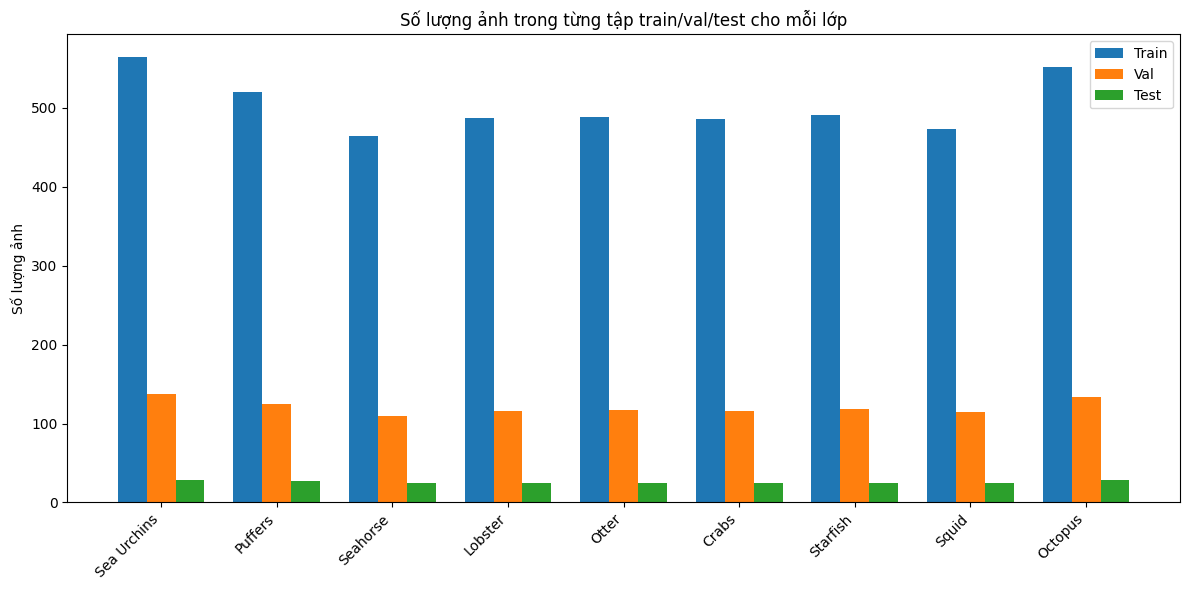

In [11]:
import matplotlib.pyplot as plt

# Chuẩn bị dữ liệu để vẽ biểu đồ
split_counts = {'train': [], 'val': [], 'test': []}

for split in ['train', 'val', 'test']:
    for class_name in classes:
        class_path = os.path.join(output_dir, split, class_name)
        if os.path.exists(class_path):
            count = len(os.listdir(class_path))
        else:
            count = 0
        split_counts[split].append(count)

# Vẽ biểu đồ
x = range(len(classes))  # trục x là chỉ số lớp
width = 0.25  # độ rộng cột

plt.figure(figsize=(12, 6))
plt.bar([i - width for i in x], split_counts['train'], width=width, label='Train')
plt.bar(x, split_counts['val'], width=width, label='Val')
plt.bar([i + width for i in x], split_counts['test'], width=width, label='Test')

plt.xticks(x, classes, rotation=45, ha='right')
plt.ylabel('Số lượng ảnh')
plt.title('Số lượng ảnh trong từng tập train/val/test cho mỗi lớp')
plt.legend()
plt.tight_layout()
plt.show()
